<a href="https://colab.research.google.com/github/nina-prog/DataAnalysis_VAE/blob/main/VAE_v1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Data Preprocessing

---



## Load Data

In [3]:
### Load ecg5000 data using read_csv
ecg5000 = pd.read_csv('ECG5000_ALL.txt', sep='\s+', header=None)

### Delete label-column first (column 0)
ecg5000.drop(ecg5000.columns[[0]], axis=1, inplace=True)

In [ ]:
### Optional test and info about data set
print("Type of ecg5000: \t \t {}".format(type(ecg5000)))
print("Dimensions of ecg5000: \t \t {}".format(ecg5000.shape))
print("Number of elements of ecg5000: \t {}".format((ecg5000.size)))
print("Display first 10 rows of ecg5000: \n {}".format(ecg5000.head(10)))

## Scale Data

In [4]:
### Normalize dataframe with min-max-normalization to range between [-0.8, 0.8] using sklearn MinMaxScaler
min_max_scaler = MinMaxScaler(feature_range=(-0.8,0.8))
scaled_ecg5000 = pd.DataFrame(min_max_scaler.fit_transform(ecg5000))
print(scaled_ecg5000)

           0         1         2    ...       137       138       139
0     0.105202 -0.154680 -0.521072  ...  0.190712  0.256566 -0.054755
1    -0.030005 -0.331729 -0.626180  ...  0.305374  0.286734 -0.247949
2     0.043017 -0.119297 -0.541672  ...  0.225560  0.253297 -0.127667
3     0.187692 -0.016509 -0.488729  ...  0.360551  0.330726 -0.123133
4     0.230067  0.140940 -0.235867  ...  0.340140  0.363540  0.090885
...        ...       ...       ...  ...       ...       ...       ...
4995 -0.033027 -0.067751 -0.335005  ... -0.337752 -0.198844 -0.292066
4996  0.045669 -0.012746 -0.329288  ...  0.391322  0.291519  0.017785
4997 -0.064328 -0.061103 -0.263680  ... -0.229486 -0.132008 -0.158819
4998 -0.033227 -0.015091 -0.196437  ...  0.090797  0.026031 -0.064782
4999  0.220296  0.302430  0.103076  ...  0.440269  0.378969  0.077596

[5000 rows x 140 columns]


## Split Data

In [5]:
### Split Data into 80/20 Training, Test
trainDF, testDF = train_test_split(scaled_ecg5000, test_size=0.2)
# Optional test and info about new data sets
print("Shape of Training DataFrame: \t {}".format(trainDF.shape))
print("Shape of Test DataFrame: \t {}".format(testDF.shape))

Shape of Training DataFrame: 	 (4000, 140)
Shape of Test DataFrame: 	 (1000, 140)


## Reshape Data

In [6]:
### Convert to array
x_train = trainDF.to_numpy()
x_test = testDF.to_numpy()

### Reshape input into [samples, timesteps, features]
s_train = len(trainDF.index) # samples
s_test = len(testDF.index) # samples
n_train = len(trainDF.columns) # time steps
n_test = len(testDF.columns) # time steps
x_train = x_train.reshape(s_train, n_train, 1)
x_test = x_test.reshape(s_test, n_test, 1)

### Properties
print("Shape of reshaped train dataset: {}".format(x_train.shape))
print("Shape of reshaped test dataset: {}".format(x_test.shape))

Shape of reshaped train dataset: (4000, 140, 1)
Shape of reshaped test dataset: (1000, 140, 1)


# Create Sample Layer

---



In [ ]:
#############################################################sample flyer function die für vae verwendet wird

# Build Variational Autoencoder (VAE)

---



Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (InputLayer)     [(None, 140, 1)]          0         
_________________________________________________________________
Encode_1 (LSTM)              (None, 140)               79520     
_________________________________________________________________
Encode_2 (Dense)             (None, 5)                 705       
_________________________________________________________________
Decode_1 (Dense)             (None, 140)               840       
_________________________________________________________________
Decode_2 (Reshape)           (None, 140, 1)            0         
_________________________________________________________________
Decode_3 (LSTM)              (None, 140, 140)          79520     
_________________________________________________________________
Output_Layer (TimeDistribute (None, 140, 1)           

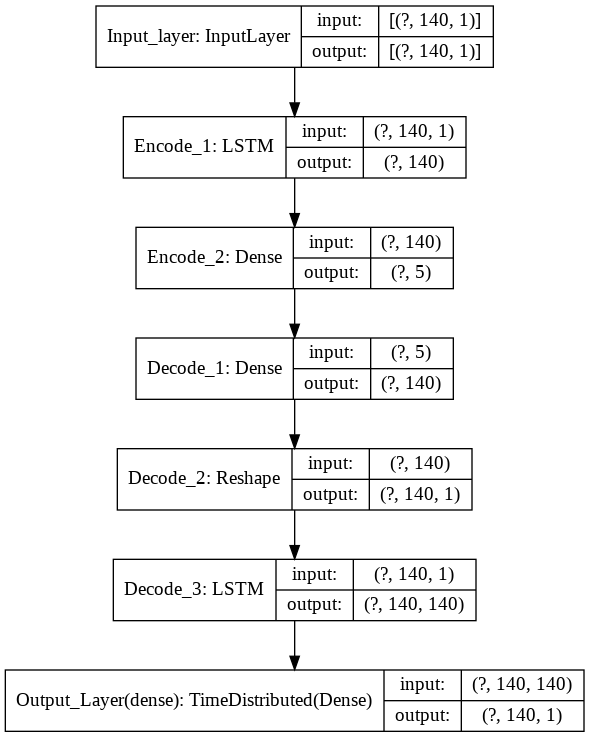

In [7]:
### For better understanding visit: https://towardsdatascience.com/autoencoders-for-the-compression-of-stock-market-data-28e8c1a2da3e
### For better understanding of layers and Recreating auto encoders visit: https://machinelearningmastery.com/lstm-autoencoders/
### or for code: https://gist.github.com/GerardBCN/40349b39bc45d4550141aff6966d1619#file-stock_price_autoencoding-ipynb
### For Reshaping Issues: https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/

### fit model
encoding_dim = 140
epochs = 50

### Define model
# Encoder
##################################################################################try bidirectional lstm , (maybe update encoding dimension in code)
inputs = keras.Input(shape=(140, 1), name='Input_layer')
encoded = layers.LSTM(encoding_dim, activation='tanh', name='Encode_1')(inputs)
encoded = layers.Dense(5, activation='tanh', name='Encode_2')(encoded)
#5, because 5 class in data ecg5000 - evtl 2,1
##################################################################################here m,sigma (VAE) Dense layer 2x
# Decoder
decoded = layers.Dense(140, activation='tanh', name='Decode_1')(encoded)
decoded = layers.Reshape((140,1), name='Decode_2')(decoded)
decoded = layers.LSTM(encoding_dim, return_sequences=True, activation='tanh', name='Decode_3')(decoded)
outputs = TimeDistributed(Dense(1, activation='tanh', name=''),name='Output_Layer')(decoded)

sequence_autoencoder = keras.Model(inputs, outputs)
encoder = keras.Model(inputs, encoded)
##################################################################################decoder = keras.Model(encoded, outputs) somewhat
sequence_autoencoder.summary()

### Train AE
##################################################################################change loss for VAE
sequence_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = sequence_autoencoder.fit(x_train, x_train,
                epochs=epochs,
                batch_size=32,
                shuffle=True,
                validation_data=(x_test, x_test))

### Recreation
decoded_ecg5000 = sequence_autoencoder.predict(x_train)
plot_model(sequence_autoencoder, show_shapes=True, to_file='reconstruct_lstm_autoencoder.png')

# Plot Results

---



In [37]:
### Test if Input fits Dim of Output
print(x_train.shape)
print(decoded_ecg5000.shape)

### Covert to 2D DataFrame
new_x_train= x_train.reshape(-1,140)
new_decoded_ecg5000 = decoded_ecg5000.reshape(-1,140)

print(new_x_train.shape)
print(new_decoded_ecg5000.shape)

(4000, 140, 1)
(4000, 140, 1)
(4000, 140)
(4000, 140)


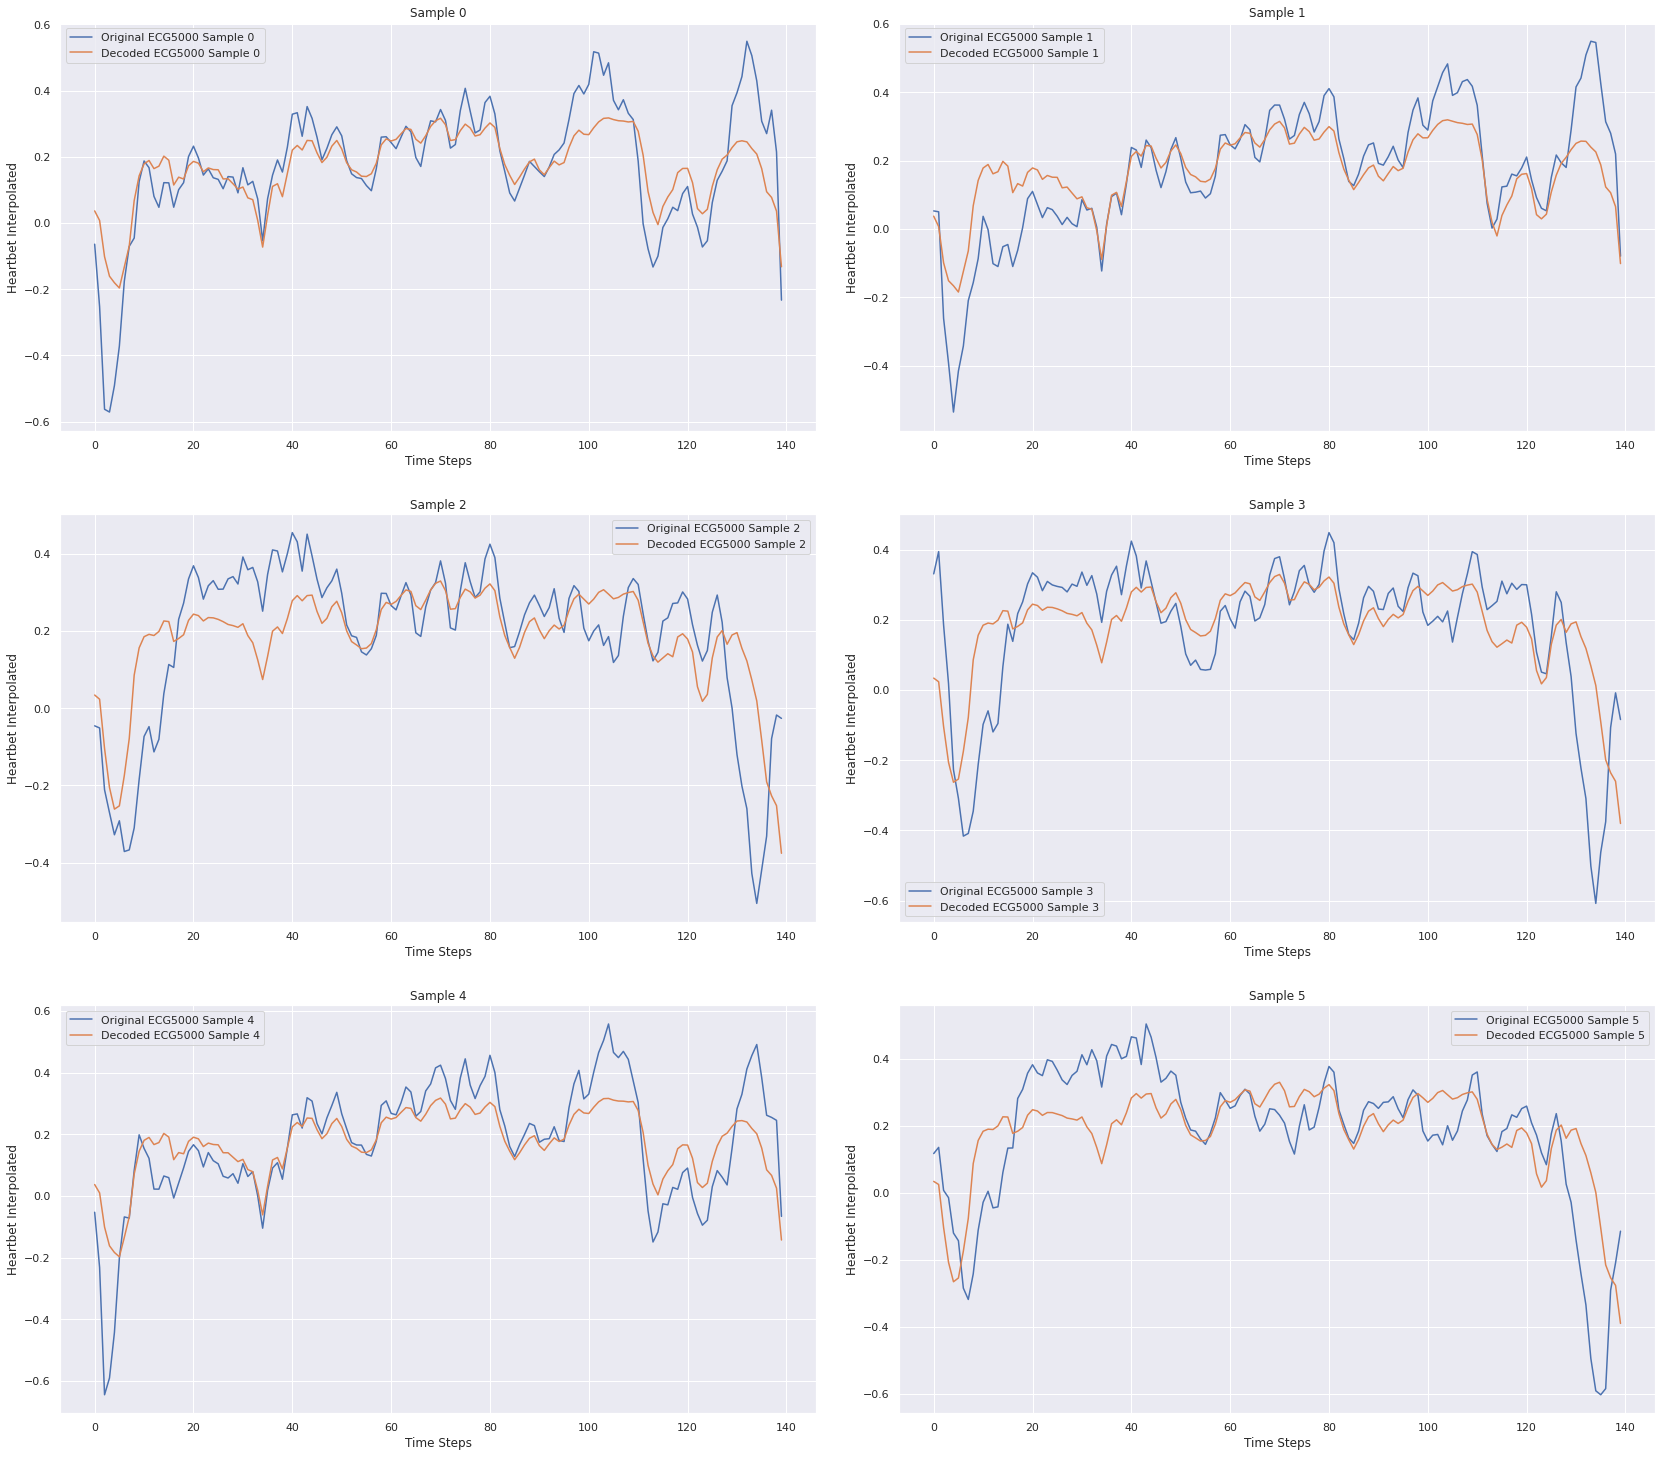

In [67]:
### Plot Multiple Times
n_rows = 3                     
n_cols = 2

fig, axs = plt.subplots(nrows = n_rows, ncols = n_cols, figsize=(23,20))
fig.tight_layout(w_pad=4, h_pad = 5)

i = 0
for row in range(n_rows):
  for col in range(n_cols):
    axs[row, col].plot(new_x_train[i])
    axs[row, col].plot(new_decoded_ecg5000[i])
    axs[row, col].legend(["Original ECG5000 Sample {}".format(i), "Decoded ECG5000 Sample {}".format(i)])
    axs[row, col].set(xlabel = "Time Steps", ylabel = "Heartbet Interpolated", title = "Sample {}".format(i))
    i = i + 1
